In [24]:
suppressPackageStartupMessages(library(ggExtra))
suppressPackageStartupMessages(library(textclean))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))

In [11]:
hfv_threshold = 100000

ordered_RBD_mutation_list <- c("A520S", "N501Y", "S477N", "L452R", "N501T", "S494P", "T478K", "K417N", "E484K", "E484Q", "K417T")

class1_epitope <- c(403, 405, 406, 417, 420, 421, 453, 455:460, 473:476, 486, 487, 489, 504)
class2_epitope <- c(472, 483:485, 490:494) 
class3_epitope <- c(345,346,437:452,496,498:501)
class4_epitope <- c(365:372, 382:386)

orf1ab_tbl <- data.table::fread("data/ORF1a__ORF1b_CDS.curated.csv", stringsAsFactors = FALSE)
orf1ab_tbl[11:16,]$Product <- substr(orf1ab_tbl$Note[11:16], 0, 5)


escape_tbl <- data.table::fread("https://media.githubusercontent.com/media/jbloomlab/SARS2_RBD_Ab_escape_maps/main/processed_data/escape_data.csv", header = TRUE, stringsAsFactors = FALSE) %>%
    mutate(
        Mutation = paste0(wildtype, site, mutation)
    )

binding_table <- data.table::fread("https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS/master/results/single_mut_effects/single_mut_effects.csv", stringsAsFactors = FALSE) %>% 
    filter(
        wildtype != mutant & 
        mutant != "*"
    )  %>%
    mutate(
        mutation = gsub('["]', '', mutation)
    )

binding_table_omicron <- data.table::fread("https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS_Omicron/main/results/final_variant_scores/final_variant_scores.csv", stringsAsFactors = FALSE, quote = "") %>%
    filter(wildtype != mutant & mutant != "*")


In [20]:
fubar_output <- data.table::fread('data/selective_landscape/2022-09_hyphy_fubar_output.csv', stringsAsFactors = FALSE) %>%
    mutate(gene = if_else(gene=="S", "Spike", gene)) %>%
    mutate(protein = if_else(protein=="S", "Spike", protein)) %>%
    arrange(gene, site) 


historic_analysis_files <- list.files("data/selective_landscape/", recursive = FALSE, full.names = FALSE, pattern = "_hyphy_fubar_output.csv")
historic_analysis_dates <- gsub("_hyphy_fubar_output.csv", "", historic_analysis_files)


fubar_historic_output <- list()
for(file in historic_analysis_files){
    historic_analysis_date <- gsub("_hyphy_fubar_output.csv", "", file)
    fubar_historic_output[[historic_analysis_date]] <- data.table::fread(paste0("data/selective_landscape/", file), stringsAsFactors = FALSE) %>%
    mutate(
        gene = if_else(gene=="S", "Spike", gene),
        protein = if_else(protein=="S", "Spike", protein),
        position = paste0(protein, ": ", site)
    )
}

In [21]:
mutation_list <- data.table::fread("data/20221003_Spike_variant_freq_13088840genomes.csv", stringsAsFactors = FALSE) %>% 
    filter(
        mutation!="WT"
    ) %>% 
    mutate(
        Mutation = paste0(gene, ": ", mutation)
    )

cat(paste0(format(nrow(mutation_list), big.mark=","), " unique Spike mutations\n"))
RBD_HFV_mutation_list <- mutation_list %>% filter(site %in% 331:531 & count > hfv_threshold)
cat(paste0(format(nrow(RBD_HFV_mutation_list), big.mark=","), " HFV RBD mutations\n"))


22,424 unique Spike mutations
25 HFV RBD mutations


In [23]:
ordered_RBD_mutation_list <- mutation_list %>%
    filter(
        count > 1000000 &
        site %in% 331:531 &
        site %in% (
            fubar_output %>% 
            filter(
                gene == "Spike" & 
                 `Prob[alpha<beta]` > 0.9
            ) %>% 
            pull(site)
        ) 
        
    ) %>%
    mutate(
        Mutation = gsub("Spike: ", "", Mutation)
    ) %>% 
    pull(Mutation)


In [ ]:
if(FALSE){
    library(xlsx)
    
    all_mutation_list <- dbGetQuery(
        conn = bicsDB,
        statement = paste0(
            "SELECT M.id as `Mutation Id`, 
                    P.name as protein,
                    M.position as site,
                    M.wt_res as wt_res,
                    M.mutant_res as mutant_res,
                    CONCAT(P.name, ': ', M.wt_res, M.position, M.mutant_res) as mutation,
                    COUNT(G.genome_id) as count
            FROM mutations M
            JOIN proteins P on P.id=M.protein_id 
            JOIN genome_mutations G on G.mutation_id=M.id
            GROUP BY G.mutation_id"
        )
    ) %>%
    mutate(
        protein = case_when(
            !grepl("^NS", protein) ~ protein,
            grepl("^NS", protein) ~ tolower(protein)
        ),
        protein = case_when(
            protein == "nsp11" ~ "nsp12",
            protein %in% orf1ab_tbl$Product ~ protein,
            protein == "ns3" ~ "ORF3a",
            grepl("^ns", protein) & !(protein %in% orf1ab_tbl$Product) ~ gsub("ns[p]*", "ORF", protein),
            !grepl("^ns", protein) ~ protein
        )
    ) 
    cat(paste0(format(nrow(all_mutation_list), big.mark=","), " total  mutations\n"))

}

# Compare to mutation effect on binding affinity

In [42]:
summarize_effects <- function(df, strain_name = ""){
                                
    cat(paste0(
        if_else(strain_name == "", "", paste0("Background lineage = ", strain_name, "\n\n")),
        
        "ACE2 Binding, Positive vs Not Positive Sites p = ", 
        signif(wilcox.test(
            df %>% filter(selection == "Positive\nSelection") %>% pull(bind_avg),
            df %>% filter(selection != "Positive\nSelection") %>% pull(bind_avg)
        )$p.value, 3),
        "\nACE2 Binding, Positive vs Purifying Sites p = ", 
        signif(wilcox.test(
            df %>% filter(selection == "Positive\nSelection") %>% pull(bind_avg),
            df %>% filter(selection == "Purifying\nSelection") %>% pull(bind_avg)
        )$p.value, 3),
        "\nACE2 Binding, Positive vs Neutral Sites p = ", 
        signif(wilcox.test(
            df %>% filter(selection == "Positive\nSelection") %>% pull(bind_avg),
            df %>% filter(selection == "None") %>% pull(bind_avg)
        )$p.value, 3),
        "\nACE2 Binding, Purifying vs Neutral Sites p = ",
        signif(wilcox.test(
            df %>% filter(selection == "Purifying\nSelection") %>% pull(bind_avg),
            df %>% filter(selection == "None") %>% pull(bind_avg)
        )$p.value, 3),


        "\n\nRBD Expression, Positive vs Not Positive Sites p = ", 
        signif(wilcox.test(
            df %>% filter(selection == "Positive\nSelection") %>% pull(expr_avg),
            df %>% filter(selection != "Positive\nSelection") %>% pull(expr_avg)
        )$p.value, 3),
        "\nRBD Expression, Positive vs Purifying Sites p = ", 
        signif(wilcox.test(
            df %>% filter(selection == "Positive\nSelection") %>% pull(expr_avg),
            df %>% filter(selection == "Purifying\nSelection") %>% pull(expr_avg)
        )$p.value, 3),
        "\nRBD Expression, Positive vs Neutral Sites p = ", 
        signif(wilcox.test(
            df %>% filter(selection == "Positive\nSelection") %>% pull(expr_avg),
            df %>% filter(selection == "None") %>% pull(expr_avg)
        )$p.value, 3),
        "\nRBD Expression, Purifying vs Neutral Sites p = ", 
        signif(wilcox.test(
            df %>% filter(selection == "Purifying\nSelection") %>% pull(expr_avg),
            df %>% filter(selection == "None") %>% pull(expr_avg)
        )$p.value, 3),


        "\n\nMutations at sites under Purifying Selection that lose binding OR expression: ", 
        tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  < 0 | expr_avg < 0 )) %>% nrow(), " / ",
        tmp %>% filter(selection == "Purifying\nSelection")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  < 0 | expr_avg < 0 )) %>% nrow()) / 
            (tmp %>% filter(selection == "Purifying\nSelection"  )%>% nrow()), 1
        ), "%",
        "\nMutations at sites under Neutral Selection that lose binding OR expression: ", 
        tmp %>% filter(selection == "None" & (bind_avg  < 0 | expr_avg < 0 )) %>% nrow(), " / ",
        tmp %>% filter(selection == "None")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "None" & (bind_avg  < 0 | expr_avg < 0 )) %>% nrow()) / 
            (tmp %>% filter(selection == "None"  )%>% nrow()), 1
        ), "%",
        "\nMutations at sites under Positive Selection that lose binding OR expression: ", 
        tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < 0 | expr_avg < 0 )) %>% nrow(), " / ",
        tmp %>% filter(selection == "Positive\nSelection")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < 0 | expr_avg < 0 )) %>% nrow()) / 
            (tmp %>% filter(selection == "Positive\nSelection"  )%>% nrow()), 1
        ), "%",


        "\n\nMutations at sites under Purifying Selection that lose binding AND expression: ", 
        tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  < 0 & expr_avg < 0 )) %>% nrow(), " / ",
        tmp %>% filter(selection == "Purifying\nSelection")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  < 0 & expr_avg < 0 )) %>% nrow()) / 
            (tmp %>% filter(selection == "Purifying\nSelection"  )%>% nrow()), 1
        ), "%",
        "\nMutations at sites under Neutral Selection that lose binding AND expression: ", 
        tmp %>% filter(selection == "None" & (bind_avg  < 0 & expr_avg < 0 )) %>% nrow(), " / ",
        tmp %>% filter(selection == "None")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "None" & (bind_avg  < 0 & expr_avg < 0 )) %>% nrow()) / 
            (tmp %>% filter(selection == "None"  )%>% nrow()), 1
        ), "%",
        "\nMutations at sites under Positive Selection that lose binding AND expression: ", 
        tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < 0 & expr_avg < 0 )) %>% nrow(), " / ",
        tmp %>% filter(selection == "Positive\nSelection")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < 0 & expr_avg < 0 )) %>% nrow()) / 
            (tmp %>% filter(selection == "Positive\nSelection"  )%>% nrow()), 1
        ), "%",


        "\n\nMutations at sites under Purifying Selection that lose substantial binding OR expression: ", 
            tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  <(-1) | expr_avg < (-1) )) %>% nrow(), " / ",
            tmp %>% filter(selection == "Purifying\nSelection")%>% nrow(), " - ",
            round( 100*
                (tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  < (-1) | expr_avg < (-1) )) %>% nrow()) / 
                (tmp %>% filter(selection == "Purifying\nSelection"  )%>% nrow()), 1
            ), "%",
            "\nMutations at sites under Neutral Selection that lose substantial binding OR expression: ", 
            tmp %>% filter(selection == "None" & (bind_avg  < (-1) | expr_avg < (-1) )) %>% nrow(), " / ",
            tmp %>% filter(selection == "None")%>% nrow(), " - ",
            round( 100*
                (tmp %>% filter(selection == "None" & (bind_avg  < (-1) | expr_avg < (-1) )) %>% nrow()) / 
                (tmp %>% filter(selection == "None"  )%>% nrow()), 1
            ), "%",
            "\nMutations at sites under Positive Selection that lose substantial binding OR expression: ", 
            tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < (-1) | expr_avg < (-1) )) %>% nrow(), " / ",
            tmp %>% filter(selection == "Positive\nSelection")%>% nrow(), " - ",
            round( 100*
                (tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < (-1) | expr_avg < (-1) )) %>% nrow()) / 
                (tmp %>% filter(selection == "Positive\nSelection"  )%>% nrow()), 1
            ), "%",


        "\n\nMutations at sites under Purifying Selection that lose substantial binding AND expression: ", 
        tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  <(-1) & expr_avg < (-1) )) %>% nrow(), " / ",
        tmp %>% filter(selection == "Purifying\nSelection")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "Purifying\nSelection" & (bind_avg  < (-1) & expr_avg < (-1) )) %>% nrow()) / 
            (tmp %>% filter(selection == "Purifying\nSelection"  )%>% nrow()), 1
        ), "%",
        "\nMutations at sites under Neutral Selection that lose substantial binding AND expression: ", 
        tmp %>% filter(selection == "None" & (bind_avg  < (-1) & expr_avg < (-1) )) %>% nrow(), " / ",
        tmp %>% filter(selection == "None")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "None" & (bind_avg  < (-1) & expr_avg < (-1) )) %>% nrow()) / 
            (tmp %>% filter(selection == "None"  )%>% nrow()), 1
        ), "%",
        "\nMutations at sites under Positive Selection that lose substantial binding AND expression: ", 
        tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < (-1) & expr_avg < (-1) )) %>% nrow(), " / ",
        tmp %>% filter(selection == "Positive\nSelection")%>% nrow(), " - ",
        round( 100*
            (tmp %>% filter(selection == "Positive\nSelection" & (bind_avg  < (-1) & expr_avg < (-1) )) %>% nrow()) / 
            (tmp %>% filter(selection == "Positive\nSelection"  )%>% nrow()), 1
        ), "%"
    ))  
}

Warning message:
“Removed 48 rows containing missing values (geom_point).”


Background lineage = Omicron_BA2

ACE2 Binding, Positive vs Not Positive Sites p = 3.49e-13
ACE2 Binding, Positive vs Purifying Sites p = 4.98e-18
ACE2 Binding, Positive vs Neutral Sites p = 3.65e-09
ACE2 Binding, Purifying vs Neutral Sites p = 7.32e-07

RBD Expression, Positive vs Not Positive Sites p = 4.41e-62
RBD Expression, Positive vs Purifying Sites p = 7.77e-65
RBD Expression, Positive vs Neutral Sites p = 3.85e-51
RBD Expression, Purifying vs Neutral Sites p = 1.55e-08

Mutations at sites under Purifying Selection that lose binding OR expression: 1092 / 1159 - 94.2%
Mutations at sites under Neutral Selection that lose binding OR expression: 2062 / 2223 - 92.8%
Mutations at sites under Positive Selection that lose binding OR expression: 398 / 437 - 91.1%

Mutations at sites under Purifying Selection that lose binding AND expression: 912 / 1159 - 78.7%
Mutations at sites under Neutral Selection that lose binding AND expression: 1589 / 2223 - 71.5%
Mutations at sites under Positi

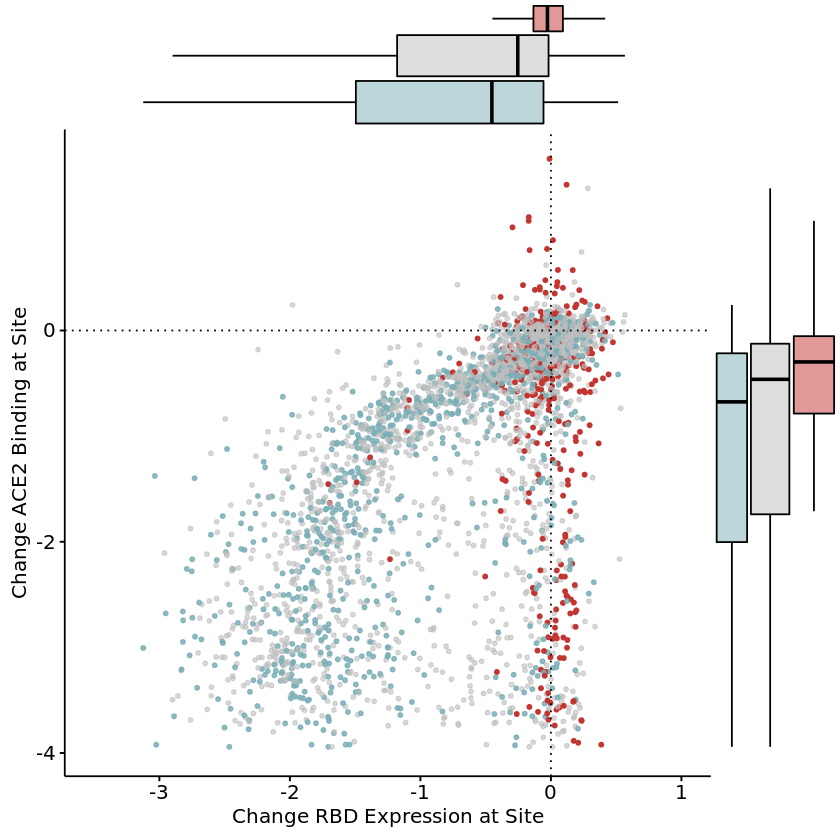

In [51]:
#background <- "Omicron_BA1"
background <- "Omicron_BA2"
#background <- "Wuhan-Hu-1_v2"
#background <- ""

if(background %in% binding_table_omicron$target){
    figure3a_data <- binding_table_omicron %>% 
        filter( target == background) %>%
        rename(
            site = position,
            bind_avg = delta_bind,
            expr_avg = delta_expr
        ) 
}else{
    figure3a_data <- binding_table %>%
        rename(
            site = site_SARS2
        )    
}
    
figure3a_data <- figure3a_data %>%
    select(site, mutation, bind_avg, expr_avg) %>%
    mutate(
        `Prob[alpha>beta]` = sapply(site, function(x) fubar_output %>% filter(gene == "Spike" & site ==x) %>% pull(`Prob[alpha>beta]`) %>% head(1)),
        `Prob[alpha<beta]` = sapply(site, function(x) fubar_output %>% filter(gene == "Spike" & site ==x) %>% pull(`Prob[alpha<beta]`) %>% head(1)),
        alpha = case_when(
            `Prob[alpha>beta]` > 0.9 ~ 0.9 ,
            `Prob[alpha<beta]` > 0.9 ~ 1,
            `Prob[alpha>beta]` < 0.9 &  `Prob[alpha<beta]` < 0.9 ~ 0.8
        ),
        selection = case_when(
            `Prob[alpha>beta]` > 0.9 ~ "Purifying\nSelection" ,
            `Prob[alpha<beta]` > 0.9 ~ "Positive\nSelection",
            `Prob[alpha>beta]` < 0.9 &  `Prob[alpha<beta]` < 0.9 ~ "None"
        ),
        selection = factor(selection, levels = rev(c("None", "Purifying\nSelection", "Positive\nSelection")))
    )        

figure3a_base <- tmp %>%
    ggscatter(
        color = "selection", 
        y = "bind_avg", 
        x = "expr_avg", 
        size =1, 
        alpha = "selection"
    ) +
    xlim(-3.5, 1) +
    ylab("Change ACE2 Binding at Site") + 
    xlab("Change RBD Expression at Site")  +
    scale_color_manual(name = "", values = rev(c('grey','#7aaeb6', "#c23531"))) + 
    geom_hline(yintercept = 0, linetype = "dotted") +
    geom_vline(xintercept = 0, linetype = "dotted")+ 
    theme(legend.position = "bottom") + 
    scale_alpha_manual(values=c("None" = 0.6, "Purifying\nSelection"=0.85, "Positive\nSelection"=1))

figure3a <- ggMarginal(
    figure3a_base + theme(legend.position = "none"), 
    type="boxplot", 
    groupFill = TRUE, 
    xparams = list(outlier.shape = NA), 
    yparams = list(outlier.shape = NA)
) 

summarize_effects(tmp, background)                                    
figure3a


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 7 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


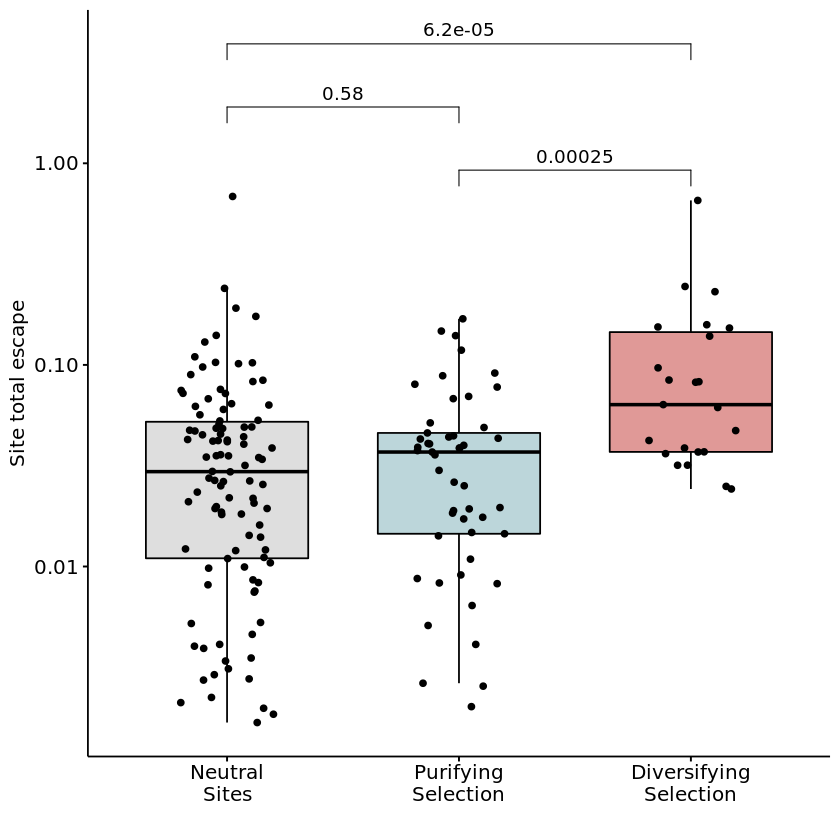

In [35]:
figure3d <- fubar_output %>%
    filter(site %in% escape_tbl$site & gene == "Spike") %>%
    mutate(
       selection = case_when(
            `Prob[alpha>beta]` > 0.9 ~ "Purifying\nSelection" ,
            `Prob[alpha<beta]` > 0.9 ~ "Diversifying\nSelection",
            `Prob[alpha>beta]` < 0.9 &  `Prob[alpha<beta]` < 0.9 ~ "Neutral\nSites"
        ),
        selection = factor(selection, levels = c("Neutral\nSites", "Purifying\nSelection", "Diversifying\nSelection")),
        site_escape = sapply(site, function(x){
            escape_tbl %>% 
                filter(site==x & condition_subtype == "convalescent serum") %>% 
                filter(!duplicated(condition)) %>% 
                pull(site_total_escape) %>% 
                mean(na.rm=T)            
        })
    ) %>%
    ggboxplot(
        x = "selection", 
        y = "site_escape", 
        add = "jitter", 
        fill = "selection", 
        alpha = 0.5,
        outlier.shape = NA
    ) +
    labs(
        x = "",
        y = "Site total escape"
    ) +
    scale_y_log10() + 
    scale_fill_manual(name = "", values = c('grey','#7aaeb6', "#c23531")) + 
    theme(legend.position = "none") +
    stat_compare_means(
        aes(label = ifelse(p < 0.05,sprintf("p = %2.1e", as.numeric(..p.format..)), ..p.format..)),
        method.args = list(alternative = "greater"), 
        comparisons = list(
            c("Diversifying\nSelection", "Purifying\nSelection"),
            c( "Neutral\nSites", "Purifying\nSelection"),
            c("Diversifying\nSelection", "Neutral\nSites")
        )
    )

figure3d



# Epitope Class vs Selection

Warning message:
“Removed 75 rows containing missing values (geom_text).”


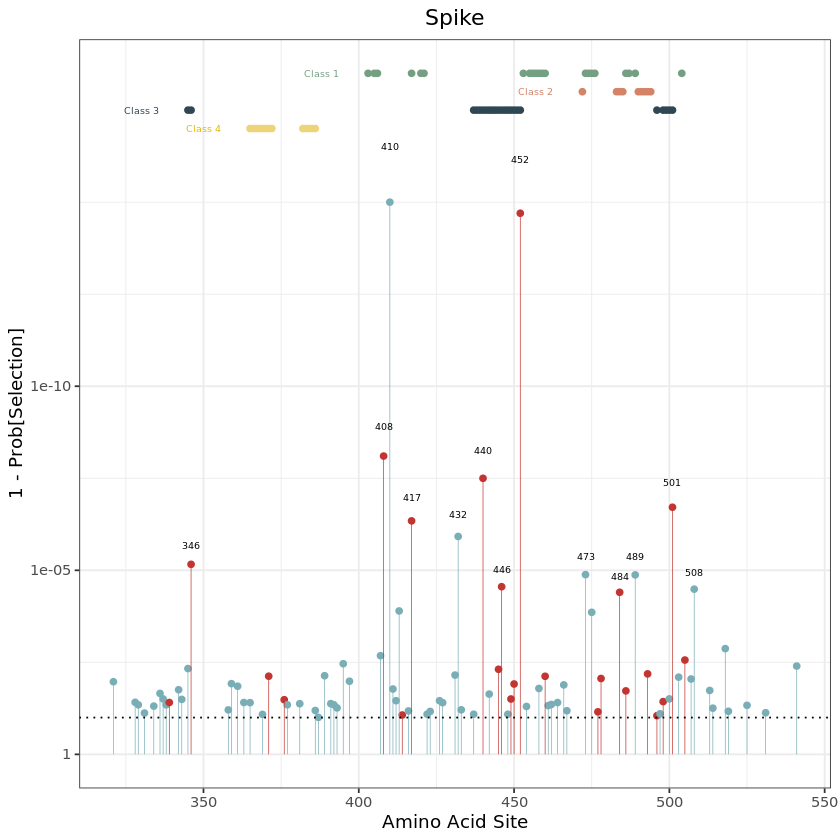

In [25]:
hide_sites <- c(302, 681)

figure3b <- fubar_output %>%
    filter(
    gene == "Spike" &
      (`Prob[alpha<beta]` > 0.9 | `Prob[alpha>beta]` > 0.9) &
      site %in% 319:541
    ) %>%
    mutate(
        selection = case_when(
          alpha < beta ~ "Positive Selection",
          alpha >= beta ~ "Purifying Selection"
        ),
        p = case_when(
          `Prob[alpha>beta]` > `Prob[alpha<beta]` ~ `Prob[alpha>beta]`,
          `Prob[alpha>beta]` <= `Prob[alpha<beta]` ~ `Prob[alpha<beta]`
        ),
        p = -1* log10(1 - p),
        p = case_when(
            p == Inf ~ 15,
            p != Inf ~ p
        ),
        label = case_when(
          # diversifying
          site == 614 ~ site,
          p > 3 & (selection == "Positive Selection") & (site %in% 319:541)  & !(site %in% hide_sites) ~ site,
          p > 4 & (selection == "Purifying Selection") & (site %in% 319:541)  & !(site %in% hide_sites) ~ site,
          p > 5 & (selection == "Positive Selection")  & !(site %in% hide_sites)  ~ site,
          p > 9 & (selection == "Purifying Selection") & !(site %in% hide_sites) ~ site
        )
    ) %>%
    ggplot(aes(site, p)) + 
    geom_point(aes(color = ifelse(alpha < beta, '1', '2'))) + 
    geom_linerange(aes(ymin = 0, ymax = p, color = ifelse(alpha < beta, '1', '2')),size = 0.2) + 
    geom_text(aes(x = site, y = p*1.1, label = label), cex = 2) +
    scale_color_manual(name = "", values = c('#c23531','#7aaeb6')) +
    xlab('Amino Acid Site') + 
    ylab('1 - Prob[Selection]') + 
    ggtitle("Spike") +
    theme_bw() +
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position= "none" 
    ) + 
    scale_y_continuous(breaks = c(0, 5, 10), labels = paste0(c(10^(-1*c(0, 5, 10))))) +
    geom_hline(yintercept = 1,linetype = 'dotted') + 
    geom_point(data = data.table(site = class1_epitope, y = 18.5), aes(x = site, y = y), color = "#749f82") + 
    geom_point(data = data.table(site = class2_epitope, y = 18), aes(x = site, y = y), color = "#d48367") + 
    geom_point(data = data.table(site = class3_epitope, y = 17.5), aes(x = site, y = y), color = "#2f4653")  + 
    geom_point(data = data.table(site = class4_epitope, y = 17), aes(x = site, y = y), color = "#edd479")+ 
    annotate("text", x = class1_epitope[1] - 15, y = 18.5, label = "Class 1", color = "#749f82", cex = 2)+ 
    annotate("text", x = class2_epitope[1] - 15, y = 18, label = "Class 2", color = "#d48367", cex = 2)+ 
    annotate("text", x = class3_epitope[1] - 15, y = 17.5, label = "Class 3", color = "#2f4653", cex = 2)+ 
    annotate("text", x = class4_epitope[1] - 15, y = 17, label = "Class 4", color = "#e6b600", cex = 2)

figure3b

Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”


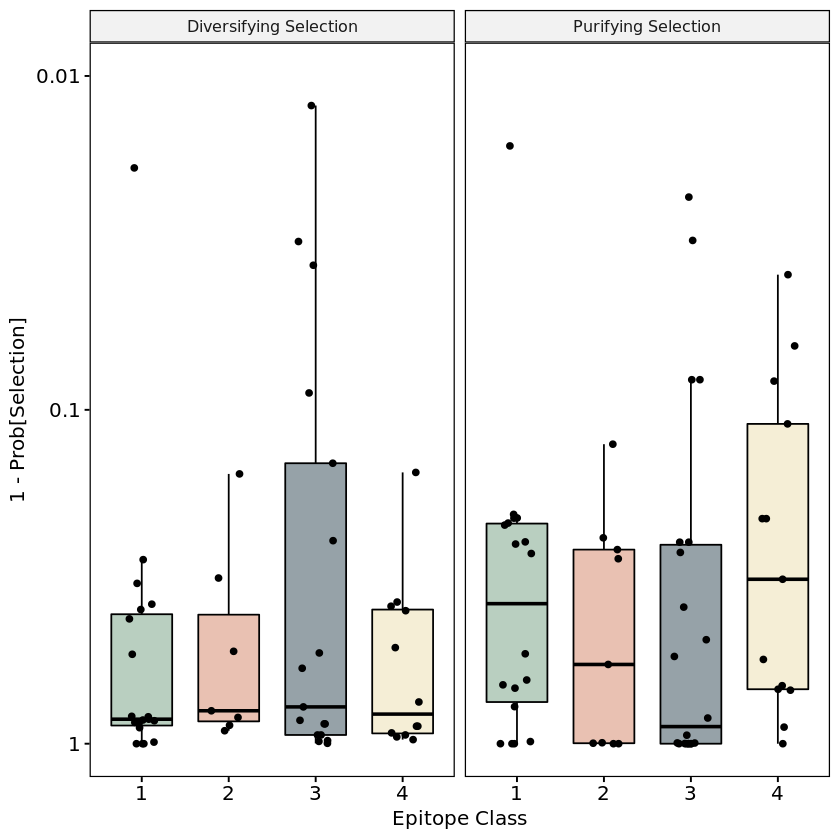

In [31]:
figure3c <- rbind(
    fubar_output %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Purifying Selection",
            prob = `Prob[alpha>beta]`
        ),
    fubar_output %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Diversifying Selection",
            prob = `Prob[alpha<beta]`
        ) 
    ) %>% 
    mutate(
        p = -1* log10(1 - prob),
        p = case_when(
            p == Inf ~ 15,
            p != Inf ~ p
        ),
        lab = case_when(
            site %in% class1_epitope ~ "1",
            site %in% class2_epitope ~ "2",
            site %in% class3_epitope ~ "3",
            site %in% class4_epitope ~ "4"
        ),
        lab = factor(lab, levels = paste0(1:4))
    )  %>% 
    ggboxplot(
        x = "lab", 
        y = "p",
        add = "jitter",
        fill = "lab",
        facet.by = "type",
        alpha = 0.5,
        outlier.shape = NA
    ) +
    xlab("Epitope Class") +
    ylab('1 - Prob[Selection]') + 
    scale_y_continuous(limits = c(0,2), breaks = c(0, 1, 2), labels = paste0(c(10^(-1*c(0, 1, 2))))) +
    scale_fill_manual(values = c("#749f82","#d48367","#2f4653","#ebdeae"), name = "") +
    theme(
        legend.position = "none"
    ) 
figure3c


In [30]:
tmp <- fubar_output %>%
    filter(
        gene == "Spike" &
        site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
    ) %>%
    mutate(
        type = "Purifying Selection",
        prob = `Prob[alpha>beta]`,
        label = case_when(
            site %in% class1_epitope ~ "1",
            site %in% class2_epitope ~ "2",
            site %in% class3_epitope ~ "3",
            site %in% class4_epitope ~ "4"
        )
    )

suppressWarnings({
    cat(paste0("Class 1/4 vs Class 2/3, p = ",
        wilcox.test(
            tmp %>% filter(label %in% c("1", "4")) %>% pull(prob),
            tmp %>% filter(label %in% c("2", "3")) %>% pull(prob),
            alternative = "greater"
        )$p.value,
       "\n\n"
    ))

    sapply(c("1", "2", "3", "4"), function(x){
        sapply(c("1", "2", "3", "4"), function(y)
            wilcox.test(
                tmp %>% filter(label == x) %>% pull(prob),
                tmp %>% filter(label == y) %>% pull(prob)
            )$p.value
        )}
    )
})

Class 1/4 vs Class 2/3, p = 0.0168573031105631



,1,2,3,4
1,1.00000000,0.1931450,0.08206418,0.9434913
2,0.19314497,1.0000000,0.83399231,0.1815694
3,0.08206418,0.8339923,1.00000000,0.1768563
4,0.94349135,0.1815694,0.17685632,1.0000000


Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”


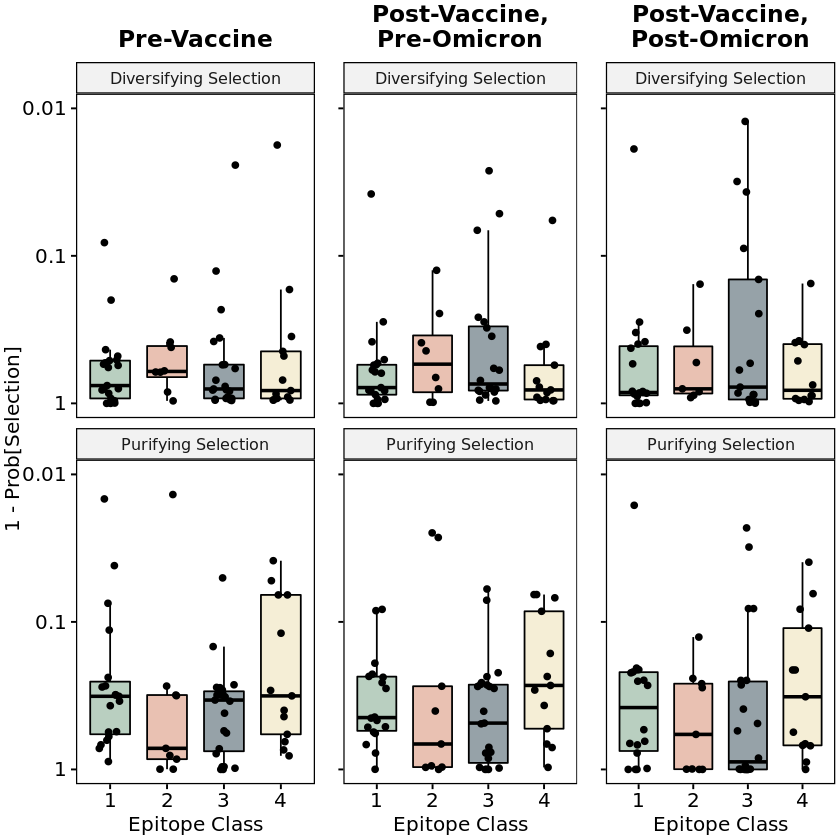

In [32]:
prevaccine_df <- rbind(
    fubar_historic_output$`2020-12` %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Purifying Selection",
            prob = `Prob[alpha>beta]`
        ),
    fubar_historic_output$`2021-03` %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Diversifying Selection",
            prob = `Prob[alpha<beta]`
        ) 
    ) %>% 
    mutate(
        p = -1* log10(1 - prob),
        p = case_when(
            p == Inf ~ 15,
            p != Inf ~ p
        ),
        lab = case_when(
            site %in% class1_epitope ~ "1",
            site %in% class2_epitope ~ "2",
            site %in% class3_epitope ~ "3",
            site %in% class4_epitope ~ "4"
        ),
        lab = factor(lab, levels = paste0(1:4))
    )

prevaccine_p <- prevaccine_df  %>% 
    ggboxplot(
        x = "lab", 
        y = "p",
        add = "jitter",
        fill = "lab",
        facet.by = "type",
        alpha = 0.5,
        outlier.shape = NA,
        nrow = 2
    ) +
    labs(
        x = "Epitope Class",
        y = '1 - Prob[Selection]',
        title = "\nPre-Vaccine"
    ) +
    scale_y_continuous(limits = c(0,2), breaks = c(0, 1, 2), labels = paste0(c(10^(-1*c(0, 1, 2))))) +
    scale_fill_manual(values = c("#749f82","#d48367","#2f4653","#ebdeae"), name = "") +
    theme(
        legend.position = "none",
        plot.title = element_text(size=14, face = "bold", hjust = 0.5),
        plot.margin = margin(0.1,0,0.1,0.1, "cm")
    ) 

postvaccine_df <- rbind(
    fubar_historic_output$`2021-09` %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Purifying Selection",
            prob = `Prob[alpha>beta]`
        ),
    fubar_historic_output$`2021-09` %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Diversifying Selection",
            prob = `Prob[alpha<beta]`
        ) 
    ) %>% 
    mutate(
        p = -1* log10(1 - prob),
        p = case_when(
            p == Inf ~ 15,
            p != Inf ~ p
        ),
        lab = case_when(
            site %in% class1_epitope ~ "1",
            site %in% class2_epitope ~ "2",
            site %in% class3_epitope ~ "3",
            site %in% class4_epitope ~ "4"
        ),
        lab = factor(lab, levels = paste0(1:4))
    )

postvaccine_p <- postvaccine_df  %>% 
    ggboxplot(
        x = "lab", 
        y = "p",
        add = "jitter",
        fill = "lab",
        facet.by = "type",
        alpha = 0.5,
        outlier.shape = NA,
        nrow = 2
    ) +
    labs(
        x = "Epitope Class",
        y = "",
        title = "Post-Vaccine,\nPre-Omicron"
    ) +
    scale_y_continuous(limits = c(0,2), breaks = c(0, 1, 2), labels = NULL) +
    scale_fill_manual(values = c("#749f82","#d48367","#2f4653","#ebdeae"), name = "") +
    theme(
        legend.position = "none",
        plot.title = element_text(size=14, face = "bold", hjust = 0.5),
        plot.margin = margin(0.1,0,0.1,0, "cm")
    ) 

postomicron_df <- rbind(
    fubar_historic_output$`2022-09` %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Purifying Selection",
            prob = `Prob[alpha>beta]`
        ),
    fubar_historic_output$`2022-09` %>%
        filter(
            gene == "Spike" &
            site %in% c(class1_epitope, class2_epitope, class3_epitope, class4_epitope)
        ) %>%
        mutate(
            type = "Diversifying Selection",
            prob = `Prob[alpha<beta]`
        ) 
    ) %>% 
    mutate(
        p = -1* log10(1 - prob),
        p = case_when(
            p == Inf ~ 15,
            p != Inf ~ p
        ),
        lab = case_when(
            site %in% class1_epitope ~ "1",
            site %in% class2_epitope ~ "2",
            site %in% class3_epitope ~ "3",
            site %in% class4_epitope ~ "4"
        ),
        lab = factor(lab, levels = paste0(1:4))
    )

postomicron_p <- postomicron_df  %>% 
    ggboxplot(
        x = "lab", 
        y = "p",
        add = "jitter",
        fill = "lab",
        facet.by = "type",
        alpha = 0.5,
        outlier.shape = NA,
        nrow = 2
    ) +
    labs(
        x = "Epitope Class",
        y = "",
        title = "Post-Vaccine,\nPost-Omicron"
    ) +
    scale_y_continuous(limits = c(0,2), breaks = c(0, 1, 2), labels = NULL) +
    scale_fill_manual(values = c("#749f82","#d48367","#2f4653","#ebdeae"), name = "") +
    theme(
        legend.position = "none",
        plot.title = element_text(size=14, face = "bold", hjust = 0.5),
        plot.margin = margin(0.1,0.1,0.1,0, "cm")
    ) 

ggarrange(
  prevaccine_p, postvaccine_p, postomicron_p,
    widths = c(1.2, 1, 1),
  nrow = 1
)



Warning message:
“Removed 20 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 20 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”


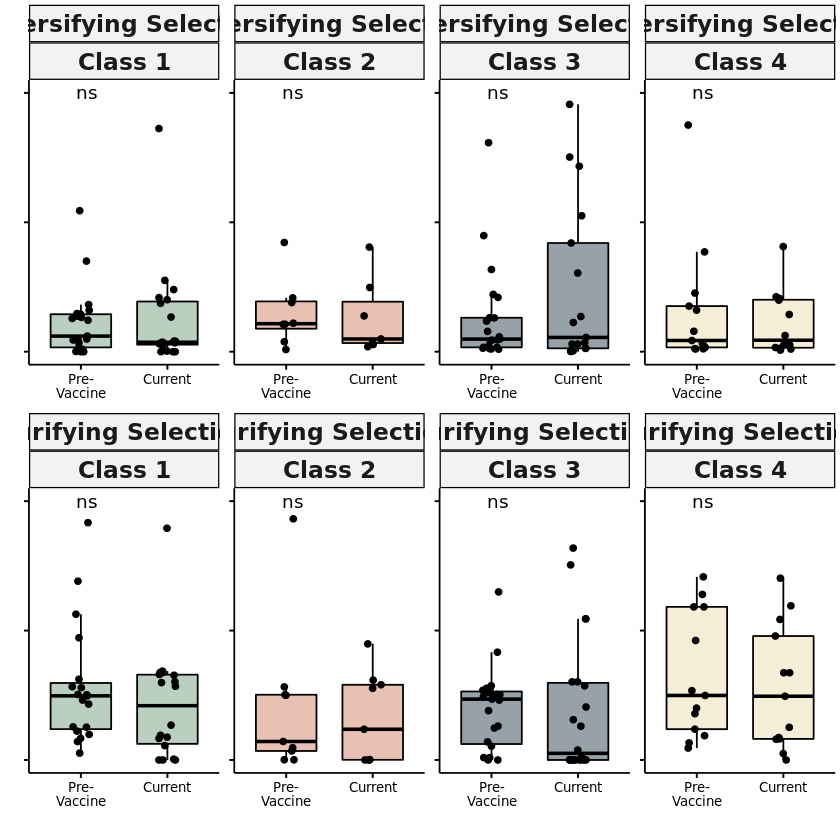

In [33]:
figure3b <- rbind(
    prevaccine_df %>% mutate(timepoint = "Pre-\nVaccine"),
    postomicron_df %>% mutate(timepoint = "Current")
) %>%
   mutate(
       timepoint = factor(timepoint, levels = c("Pre-\nVaccine", "Current")),
       lab = paste0("Class ", lab)
   ) %>%
    ggboxplot(
        x = "timepoint", 
        y = "p",
        add = "jitter",
        fill = "lab",
        alpha = 0.5,
        outlier.shape = NA
    ) +
    facet_wrap(type~lab, nrow = 2, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    scale_y_continuous(limits = c(0,2), breaks = c(0, 1, 2), labels = NULL) +
    scale_fill_manual(values = c("#749f82","#d48367","#2f4653","#ebdeae"), name = "") +
    theme(
        legend.position = "none",
        plot.title = element_text(size=14, face = "bold", hjust = 0.5),
        plot.margin = margin(0.1,0.1,0.1,0, "cm"),
        axis.text.x = element_text(size = 8),
        strip.text = element_text(size = 14, face = "bold")
    ) +
stat_compare_means(aes(label = ..p.signif..), method.args = list(alternative = "less"))

figure3b


# other